## Los problemas

A lo largo de este laboratorio deberás enfrentarte a distintos casos prácticos:

- **Caso 1: Sistema de Recomendación Basado en Contenido**

	Debes construir un sistema que recomiende videojuegos similares basándose en su descripción y géneros. Para eso deberás:

	- Preprocesar las descripciones de los juegos (texto) utilizando técnicas de NLP aprendidas durante la clase.

	- Extraer y limpiar las etiquetas de género para su uso en el sistema de recomendación.

	- Implementar una métrica de similitud (como el coseno) para recomendar juegos similares.

	- Evaluar las recomendaciones generadas para un conjunto de juegos específicos.


## Los Datos


- **1. games_description.csv**: Este archivo contiene información detallada sobre videojuegos disponibles en una tienda. Las columnas que tenemos son: 


	- **`name`**: Nombre del videojuego.

	- **`short_description`**: Breve descripción del videojuego.

	- **`long_description`**: Descripción completa y detallada del videojuego.

	- **`genres`**: Lista de géneros asociados al videojuego (por ejemplo, Acción, RPG).

	- **`minimum_system_requirement`**: Requisitos mínimos para ejecutar el videojuego.

	- **`recommend_system_requirement`**: Requisitos recomendados para ejecutar el videojuego.

	- **`release_date`**: Fecha de lanzamiento del videojuego.

	- **`developer`**: Nombre del desarrollador del videojuego.

	- **`publisher`**: Nombre del publicador del videojuego.

	- **`overall_player_rating`**: Calificación general de los jugadores (categórica).

	- **`number_of_reviews_from_purchased_people`**: Número de reseñas realizadas por personas que compraron el juego.

	- **`number_of_english_reviews`**: Número de reseñas en inglés.

	- **`link`**: Enlace al videojuego en la tienda.


----

- Los datos del archivo `games_description.csv` pueden utilizarse para construir sistemas de recomendación basados en contenido.

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd

# Para visualización de datos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

# Para cargar los datos
# -----------------------------------------------------------------------
import pickle

# Para sistemas de recomendacion basados en cotenido
# -----------------------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer # Vectorizacion / tokenizacion 
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion

# Importamos nuestras funciones
# -----------------------------------------------------------------------
from src import soporte_sistemas_recomendacion as sr

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.0f}'.format
%load_ext autoreload
%autoreload 2

In [2]:
# cargamos lso datos
df = pd.read_csv('../data/games_description.csv')
df.sample(5)


,name,short_description,long_description,genres,minimum_system_requirement,recommend_system_requirement,release_date,developer,publisher,overall_player_rating,number_of_reviews_from_purchased_people,number_of_english_reviews,link
21,Street Fighter™ 6,Here comes Capcom’s newest challenger! Street ...,About This Game\n\t\t\t\t\t\t\tHere comes Capc...,"['2D Fighter', 'Fighting', 'Character Customiz...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"1 Jun, 2023","['CAPCOM Co., Ltd.']","['CAPCOM Co., Ltd.']",Very Positive,"(29,249)","22,350",https://store.steampowered.com/app/1364780/Str...
148,World of Tanks,Jump into the free-to-play team-based shooter ...,About This Game\n\t\t\t\t\t\t\tCommand over 60...,"['Tanks', 'Free to Play', 'Action', 'Military'...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"28 Apr, 2021",['Wargaming Group Limited'],['Wargaming Group Limited'],Very Positive,"(79,113)","18,685",https://store.steampowered.com/app/1407200/Wor...
20,Call of Duty®,Call of Duty® HQ supports Call of Duty®: Black...,About This Game\n\t\t\t\t\t\t\tCall of Duty® H...,"['FPS', 'Multiplayer', 'Shooter', 'Action', 'S...",['Requires a 64-bit processor and operating sy...,['Requires a 64-bit processor and operating sy...,"28 Oct, 2022","['Sledgehammer Games', 'Treyarch', 'Infinity W...",['Activision'],Mixed,"(333,296)","299,267",https://store.steampowered.com/app/1938090/Cal...
284,PIPE by BMX Streets,PIPE is a physics based BMX experience built f...,About This Game\n\t\t\t\t\t\t\tPIPE is a physi...,"['Sports', 'Simulation', 'Indie', 'BMX', 'Bike...","['OS *: Windows 7', 'Processor: X64 Dual Core'...","['OS *: Windows 7', 'Processor: X64 Dual Core'...","15 Mar, 2018",['Mash Games'],['Mash Games'],Very Positive,"(5,350)","2,337",https://store.steampowered.com/app/815780/PIPE...
157,Supermarket Simulator,"Run your own supermarket. Stock shelves, set p...","About This Game\n""Supermarket Simulator"" is a ...","['Simulation', 'Management', 'Economy', 'Multi...","['OS: Windows (64-bit) 10', 'Processor: i5 355...","['OS: Windows (64-bit) 10', 'Processor: i5 760...","20 Feb, 2024",['Nokta Games'],['Nokta Games'],Very Positive,"(48,211)","21,084",https://store.steampowered.com/app/2670630/Sup...


In [3]:
# selecion de columnas objetivo para realizar nuestro filtro colaborativo 
df_contenido = df[["name", "genres"]]
df_contenido = df_contenido.rename(columns={'name': 'title'})
df_contenido.head()

,title,genres
0,Black Myth: Wukong,"['Mythology', 'Action RPG', 'Action', 'RPG', '..."
1,Counter-Strike 2,"['FPS', 'Shooter', 'Multiplayer', 'Competitive..."
2,"Warhammer 40,000: Space Marine 2","['Warhammer 40K', 'Action', 'Third-Person Shoo..."
3,Cyberpunk 2077,"['Cyberpunk', 'Open World', 'Nudity', 'RPG', '..."
4,ELDEN RING,"['Souls-like', 'Dark Fantasy', 'Open World', '..."


In [4]:
def tratar_filas(row):
    return row.replace("[","").replace("]","").replace(","," ").replace("\'","")

In [5]:
df_contenido['tags'] = df_contenido["genres"].apply(tratar_filas)

df_contenido = df_contenido[['title', 'tags']]
df_contenido.head()


,title,tags
0,Black Myth: Wukong,Mythology Action RPG Action RPG Souls-like...
1,Counter-Strike 2,FPS Shooter Multiplayer Competitive Action...
2,"Warhammer 40,000: Space Marine 2",Warhammer 40K Action Third-Person Shooter A...
3,Cyberpunk 2077,Cyberpunk Open World Nudity RPG Singleplay...
4,ELDEN RING,Souls-like Dark Fantasy Open World RPG Dif...


In [6]:
vectorizer = CountVectorizer(max_features=1000,stop_words= "english")

X = vectorizer.fit_transform(df_contenido['tags']).toarray()

# calculamos sus distancias
similarity = cosine_similarity(X)
similarity[:10]

array([[1.        , 0.16222142, 0.4738791 , ..., 0.17996851, 0.28676967,
        0.16754156],
       [0.16222142, 1.        , 0.36514837, ..., 0.11094004, 0.07071068,
        0.15491933],
       [0.4738791 , 0.36514837, 1.        , ..., 0.20254787, 0.25819889,
        0.28284271],
       ...,
       [0.36710862, 0.52223297, 0.25425669, ..., 0.19312182, 0.12309149,
        0.17978663],
       [0.21296184, 0.40842198, 0.31957418, ..., 0.16182268, 0.25785531,
        0.33895961],
       [0.3117146 , 0.44835883, 0.26311741, ..., 0.13323468, 0.05661385,
        0.16537965]])

In [7]:
game_usuario = 'Age of Empires II: Definitive Edition'

game_index = sr.get_index_from_title(game_usuario, df_contenido)

similar_movies = list(enumerate(similarity[game_index]))
similar_movies[:3]

[(0, np.float64(0.19088542889273336)),
 (1, np.float64(0.23533936216582085)),
 (2, np.float64(0.2506402059138015))]

In [8]:
# ordenamos las peliculas
game_similares_ordenadas = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:21] # [1:21] si lo cambiamos a [0:21] la tenemos a ella misma 
game_similares_ordenadas[:3]

[(211, np.float64(0.9413574486632834)),
 (202, np.float64(0.6240377207533827)),
 (165, np.float64(0.5462677805469223))]

C:\Users\develop\AppData\Local\Temp\ipykernel_14952\2417315933.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


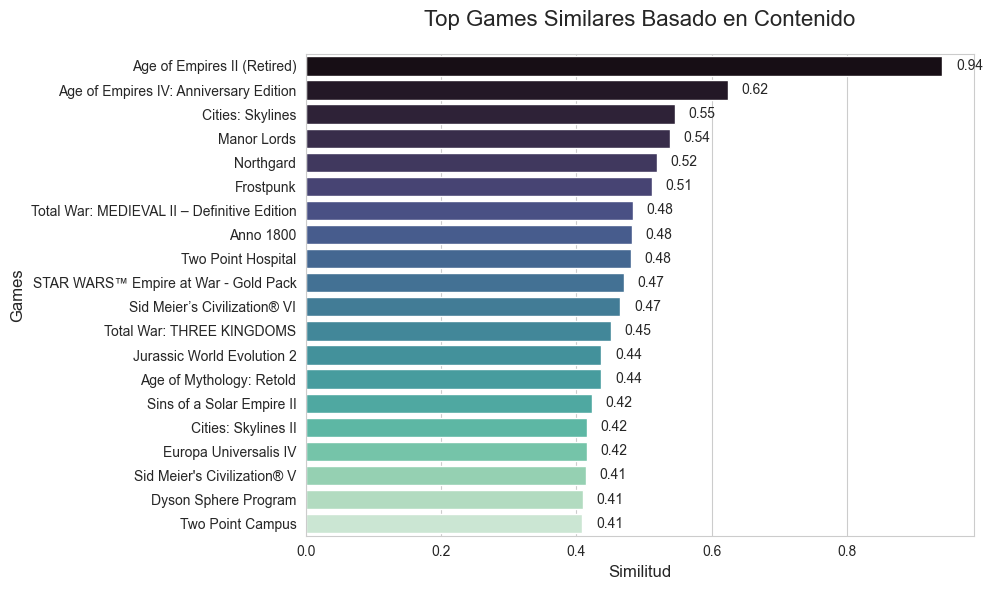

In [9]:
# y ahora buscamos el título
top_simiar_movies = {}
for i in game_similares_ordenadas:
    top_simiar_movies[sr.get_title_from_index(i[0], df_contenido)] = i[1]

# visualizamos los resultados
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Crear gráfico de barras
sns.barplot(
    x=list(top_simiar_movies.values()), 
    y=list(top_simiar_movies.keys()), 
    palette="mako"
)

# Añadir etiquetas y título
plt.title("Top Games Similares Basado en Contenido", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Games", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_simiar_movies.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()
